# Topic modelling model selection on Fetch20 dataset



## Model 1. LDA Scikit-learn implementation

In [12]:
# Imports and stopwords extension
%run pkgs/dependencies_stopwords.ipynb

# # Dataset preparation (only run once)
# %run pkgs/fetch20_dataset_preparation.ipynb

# Define data preprocessor object
%run pkgs/data_preprocessors.ipynb

# Define the sklearn LDA model with Count Vectorizer
%run pkgs/lda_modeller.ipynb

# Define auxillary functionality
%run pkgs/auxillary_functions.ipynb


# Read and preprocess the data
prep = Preprocessor(path = 'four_groups.csv')
df = prep(remove_digit_words = True, remove_short_words = True)

# df = df[df['text'].map(lambda x: len(x.split())) > 5]

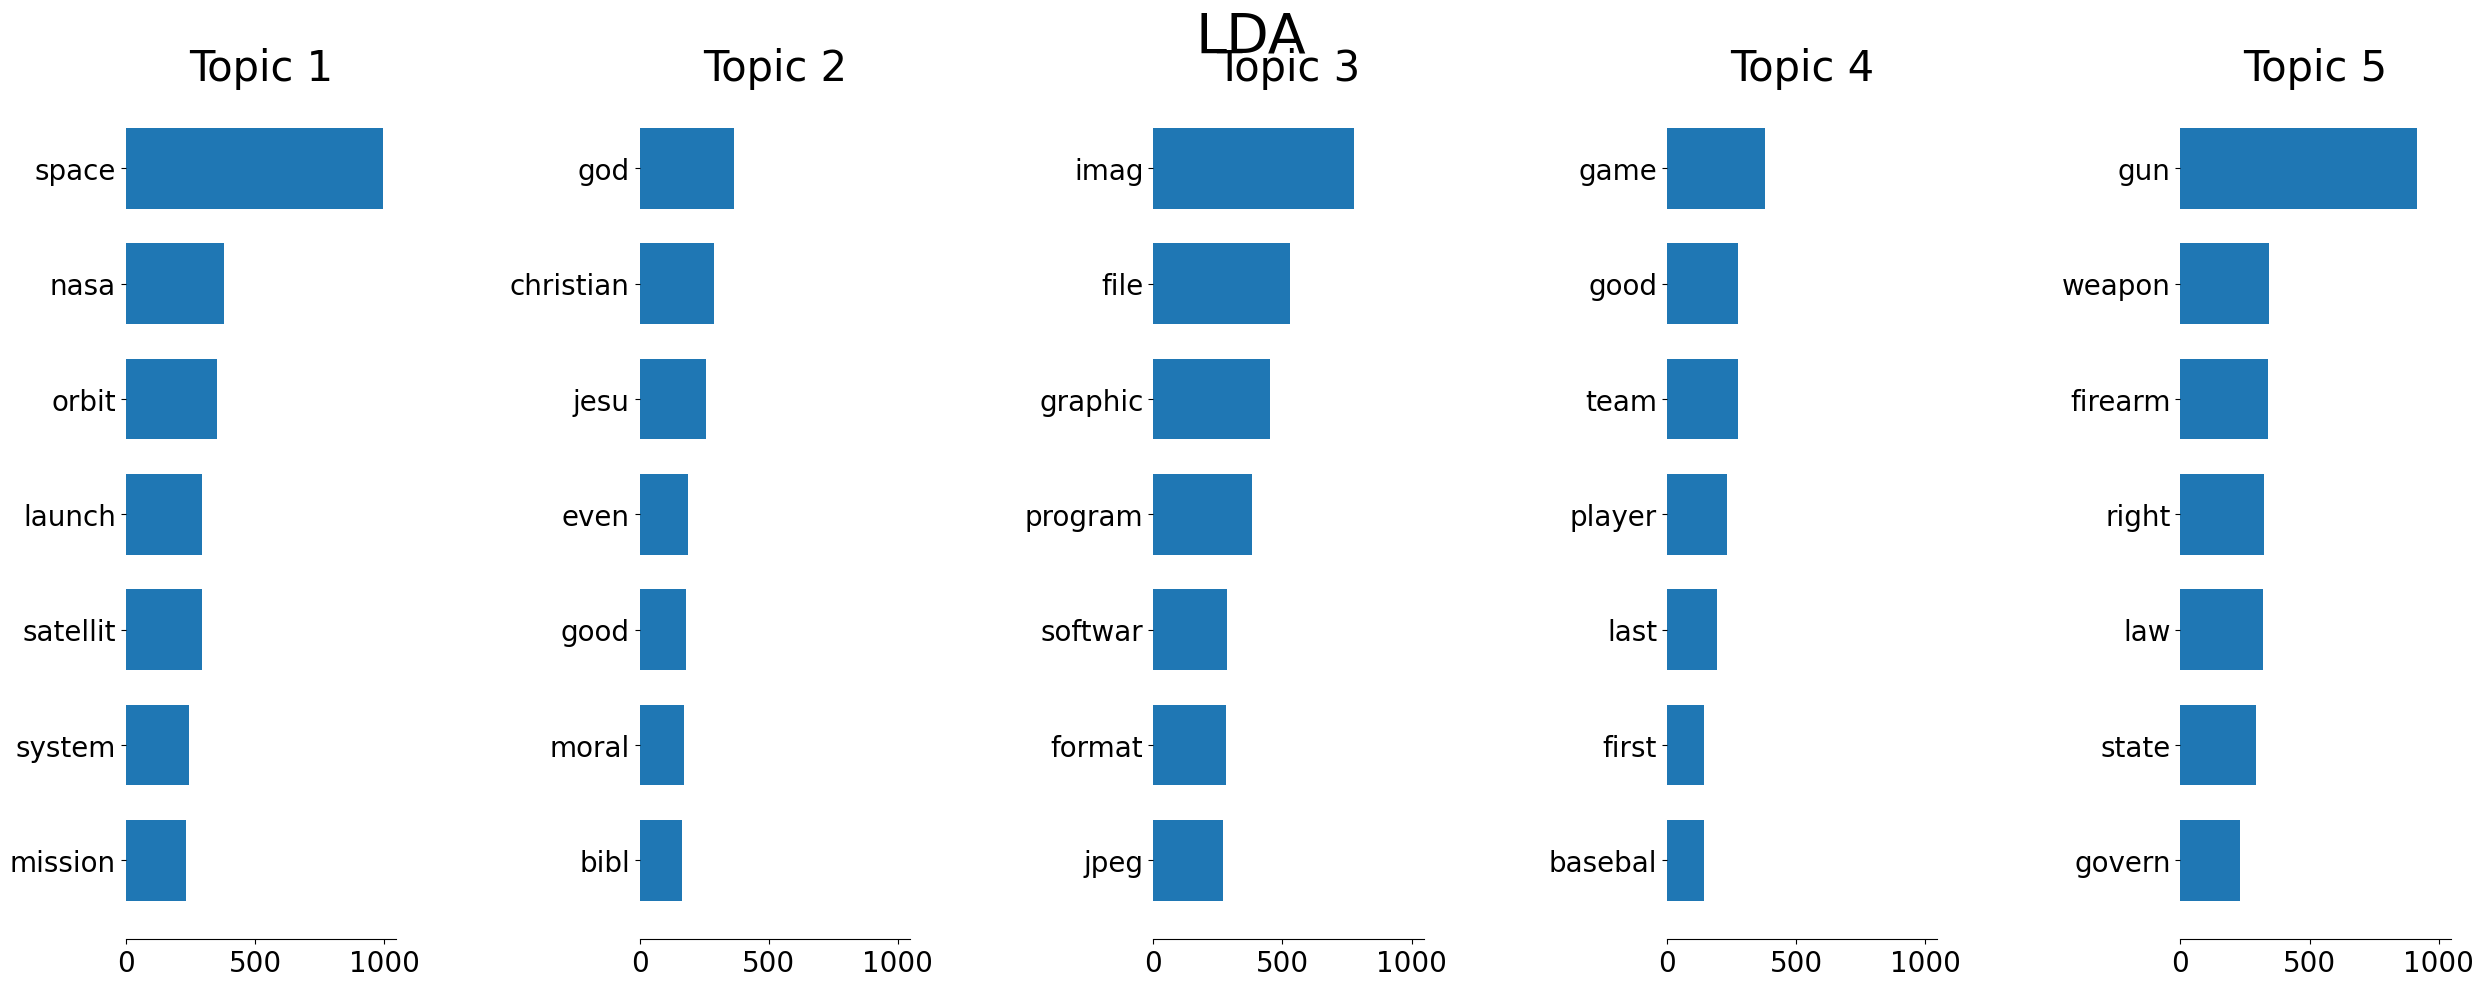

In [4]:
# Define sklearn LDA model with CountVectorizer
lda_modeller = LDAmodeller(df=df, vectorizer = 'count')
lda = lda_modeller.vectorize_fit()

# Words per topics
feature_names = lda_modeller.vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names)

# topic_vocab = {0: 'tech', 1: 'politics', 2: 'entertainment', 3: 'business', 4: 'sport'}

In [5]:
# Estimate model accuracy
topic_vocab = {0: 'space', 1: 'religion', 2: 'graphics', 3: 'sport', 4: 'politics'}

est_accuracy(topic_vocab = topic_vocab)

Supposed model accuracy: 0.8643649815043156


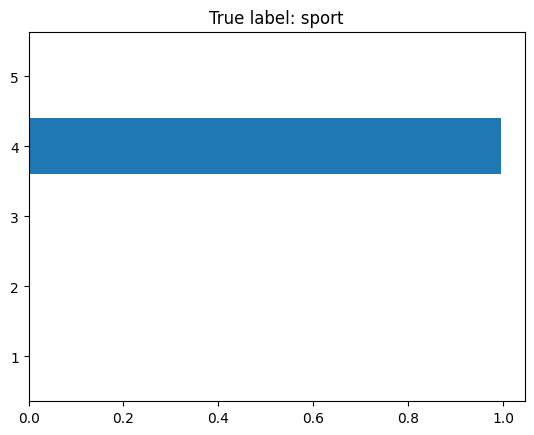

In [15]:
# Sample article topic attribution
sample_topic(rand_seed = 0, topic_vocab = topic_vocab)

# Anorther article topic attribution
# sample_topic(rand_seed=1)

In [8]:
# Calculate the coherence, perplexity scores and log likelihood scores

vocab, words, id2word = coherence_perp_logl()

The coherence score is: 0.76
The log perplexity score is: 7.709
The log likelihood is: -1318320.516


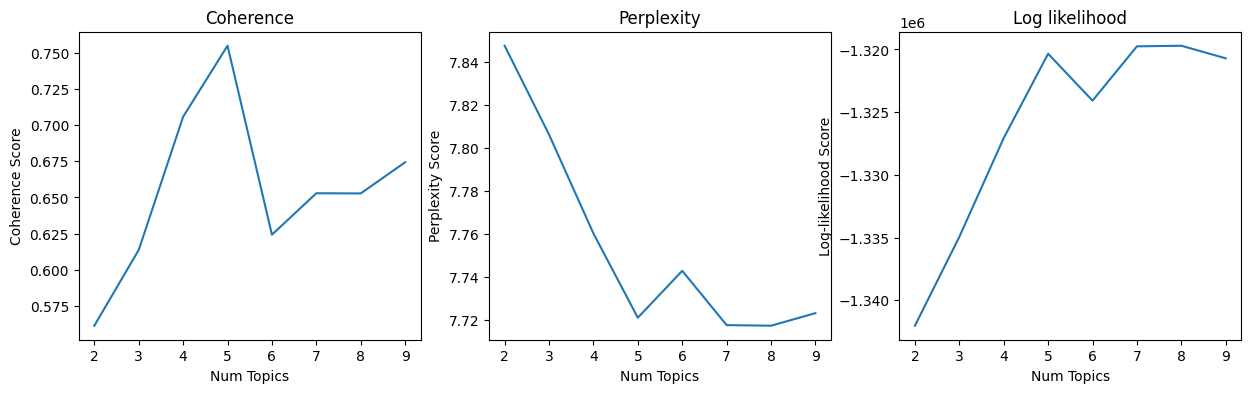

In [8]:
model_list, coherence_values, perplexity_list, log_likelihood_scores = metrics_model_selection(dictionary=id2word, words=words)

## Model 1.1 Sklearn LDA with Tfidf vectorizer

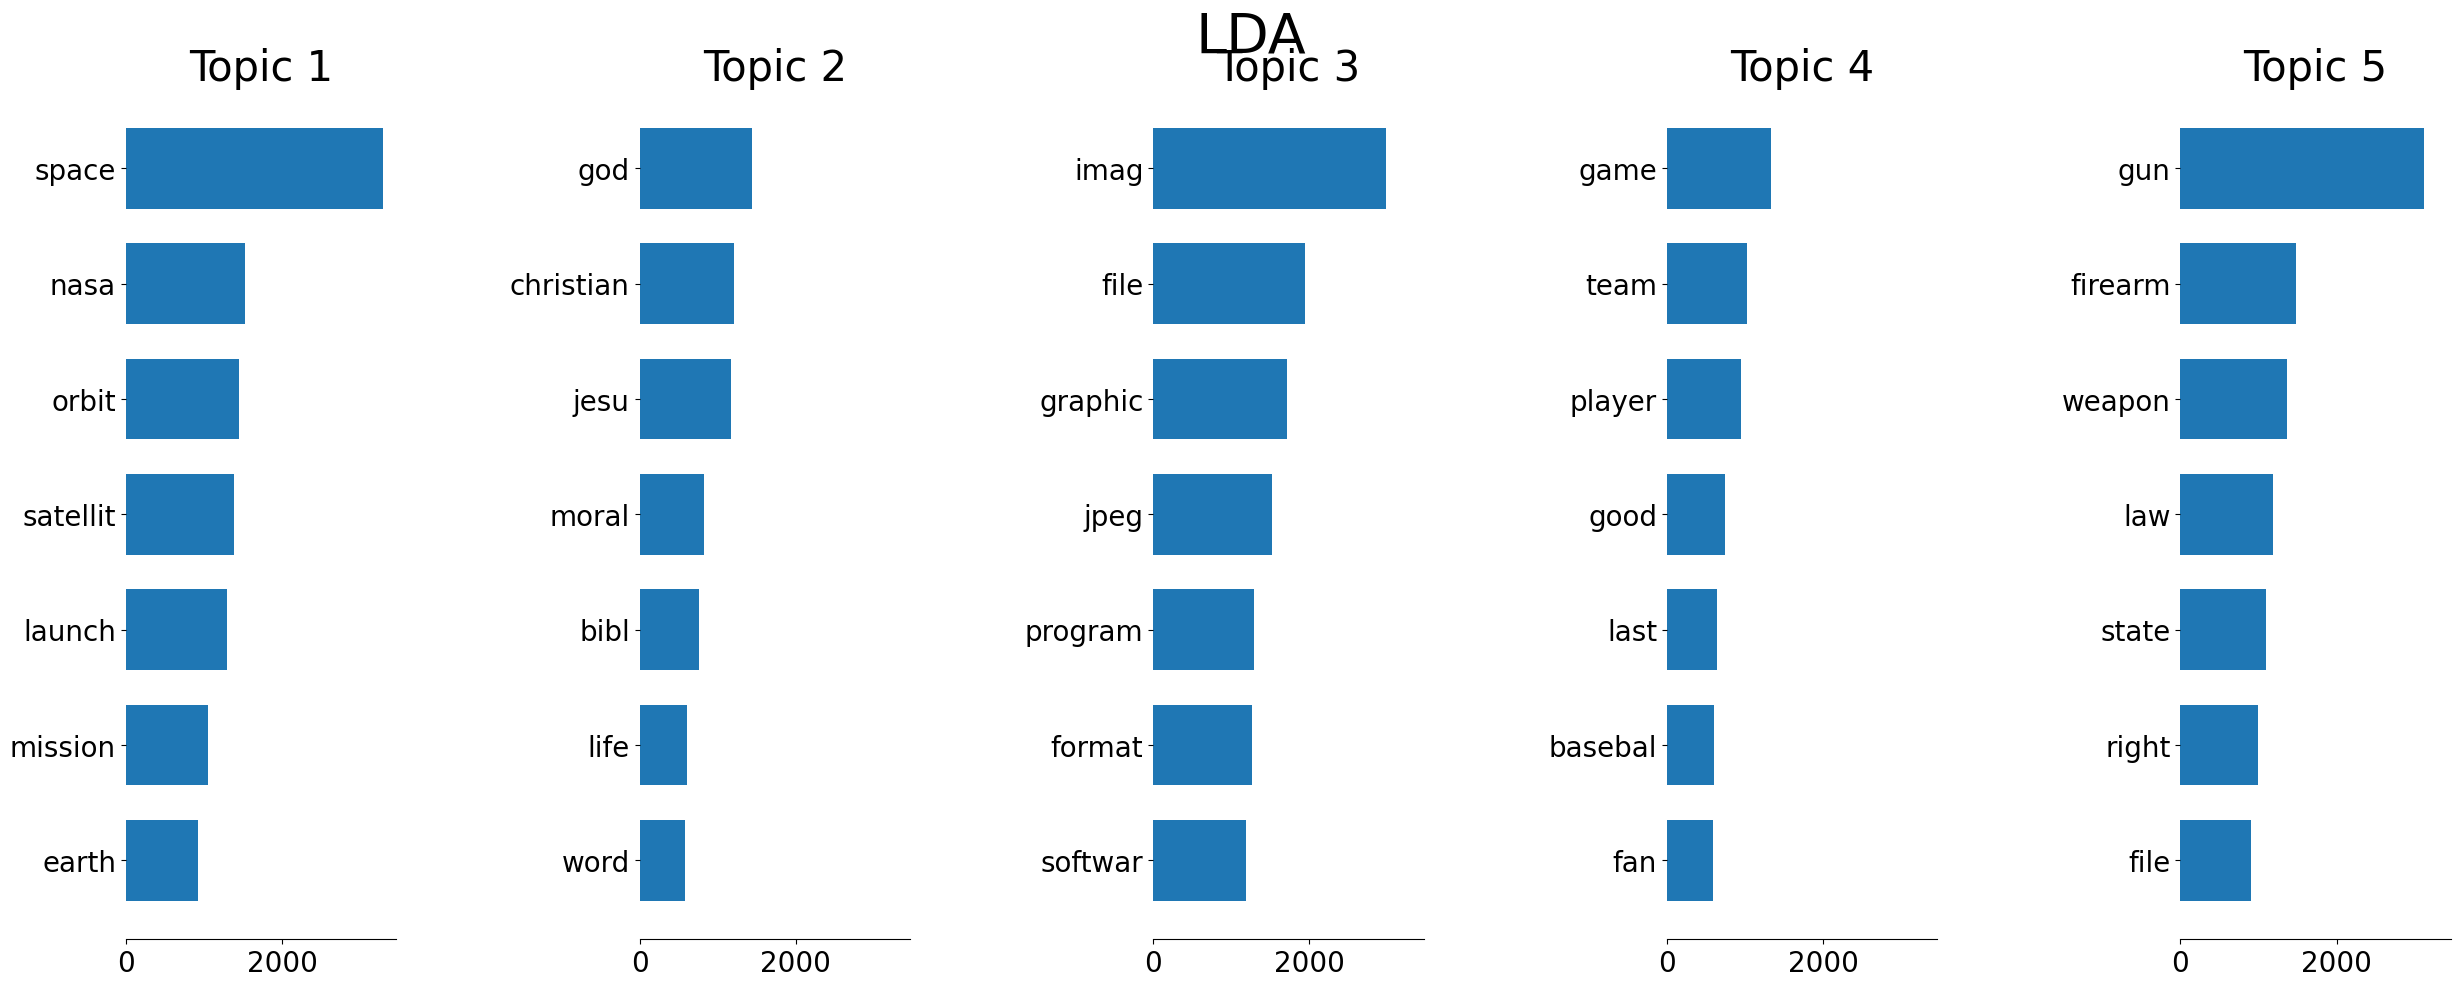

In [7]:
lda_modeller = LDAmodeller(df=df, vectorizer = 'tfidf')
lda = lda_modeller.vectorize_fit()

feature_names = lda_modeller.vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names)

W1 = lda.transform(lda_modeller.vectorized_sentences)
H1 = lda.components_

In [8]:
# Estimate model accuracy
topic_vocab = {0: 'space', 1: 'religion', 2: 'graphics', 3: 'sport', 4: 'politics'}

est_accuracy(topic_vocab = topic_vocab)

Supposed model accuracy: 0.8581997533908755


In [9]:
print_n_words_per_topic()

space nasa orbit satellit launch mission earth lunar shuttl system moon rocket technolog probe flight


god christian jesu moral bibl life word even religion child man christ good law way


imag file graphic jpeg program format softwar ftp color gif pub avail datum mail system


game team player good last basebal fan season leagu run cub pitcher win first col


gun firearm weapon law state right file crime govern handgun control crimin bill fire militia




In [10]:
# Topic per document probability distribution
df_doc_topic = topic_per_doc_matrix()
df_doc_topic.head(3)

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.0,0.00,0.0,0.00,1.00,4
Doc1,0.0,0.00,0.0,1.00,0.00,3
Doc2,0.0,0.28,0.0,0.15,0.57,4


In [13]:
vocab, words, id2word = coherence_perp_logl()

The coherence score is: 0.799
The log perplexity score is: 7.654
The log likelihood is: -6708029.332


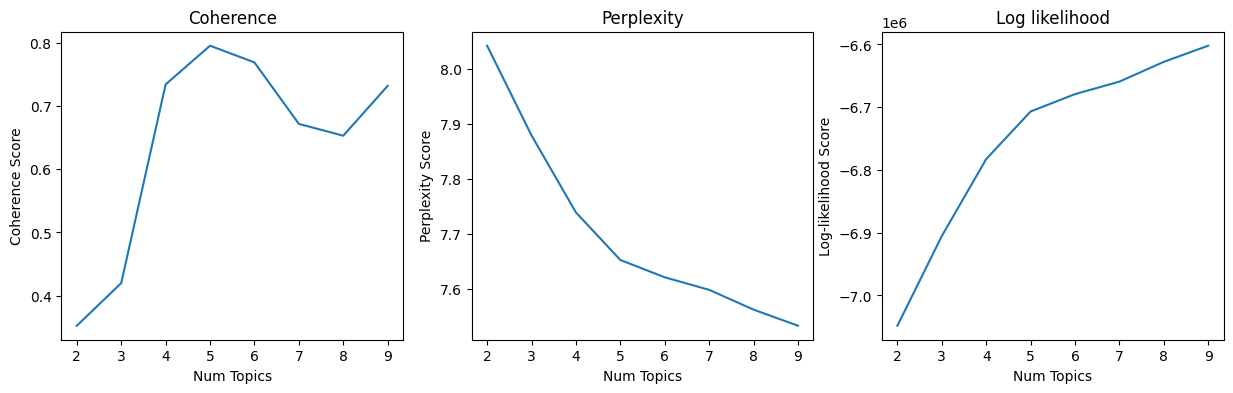

In [14]:
model_list, coherence_values, perplexity_list, log_likelihood_scores = metrics_model_selection(dictionary=id2word, words=words)

## Model 2. LDA with Gensim

In [26]:
# Create document-term matrix
def create_document_term_matrix(dataframe, column_name='text', vectorizer='count', stops=stops, min_df=2, max_df=0.95):
  if vectorizer == 'count':
    vectorizer = CountVectorizer(stop_words = list(stops),
                                        min_df = min_df,
                                        max_df = max_df)
  elif vectorizer == 'tfidf':
    vectorizer = TfidfVectorizer(stop_words = list(stops),
                                 min_df = min_df,
                                 max_df = max_df)
  else:
    raise ValueError('The vectorizer value can be either "count" or "tfidf"')
  
  data = vectorizer.fit_transform(dataframe[column_name])
  df_dtm = pd.DataFrame(data.toarray(), columns = vectorizer.get_feature_names_out())
  df_dtm.index = dataframe.index
  return df_dtm

df_dtm = create_document_term_matrix(df)

# Create bigrams and trigrams (note: only one of these will be used for modelling)
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
bigram = gensim.models.Phrases(words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

words_bigrams = make_bigrams(words)
words_trigrams = make_trigrams(words)

vectorizer = CountVectorizer(stop_words = list(stops),
                                        min_df = 2,
                                        max_df = 0.95)
X = vectorizer.fit_transform(df['text'])

id2word = corpora.Dictionary(words)

In [27]:
# id2word dictionary and corpus
id2word = corpora.Dictionary(words)

# OPTIONAL STEP!.
# Filter out tokens that appear in less than 15 documents, more than 0.5 documents (fraction of total corpus size, not absolute number) and keep only the first 100000 most frequent tokens.
# id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

corpus = [id2word.doc2bow(word) for word in words]
vocab = vectorizer.get_feature_names_out()

In [34]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = id2word, num_topics = num_topics, 
#                                        chunksize = 1000,
                                       passes = 100,
                                       iterations = 100,
                                       per_word_topics = True
                                      )

In [35]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.009*"god" + 0.007*"christian" + 0.006*"jesu" + 0.006*"good" + 0.005*"way" '
  '+ 0.005*"even" + 0.005*"thing" + 0.004*"moral" + 0.004*"point" + '
  '0.004*"mani"'),
 (1,
  '0.013*"game" + 0.010*"good" + 0.009*"team" + 0.008*"player" + 0.007*"last" '
  '+ 0.006*"well" + 0.005*"first" + 0.005*"basebal" + 0.005*"run" + '
  '0.005*"fan"'),
 (2,
  '0.011*"space" + 0.008*"launch" + 0.005*"satellit" + 0.005*"first" + '
  '0.005*"orbit" + 0.004*"rocket" + 0.004*"moon" + 0.004*"much" + 0.004*"fbi" '
  '+ 0.004*"long"'),
 (3,
  '0.024*"gun" + 0.009*"weapon" + 0.009*"firearm" + 0.008*"law" + '
  '0.008*"state" + 0.007*"right" + 0.007*"file" + 0.005*"crime" + '
  '0.005*"control" + 0.005*"govern"'),
 (4,
  '0.015*"imag" + 0.012*"space" + 0.008*"file" + 0.008*"program" + '
  '0.008*"graphic" + 0.007*"system" + 0.006*"nasa" + 0.006*"avail" + '
  '0.006*"datum" + 0.005*"softwar"')]


In [45]:
# Sample code for model "accuracy" check

new_words = [nltk.word_tokenize(sentence) for sentence in df['text']]
new_doc_dict = corpora.Dictionary(new_words)
new_doc_bow = [new_doc_dict.doc2bow(doc) for doc in new_words]
new_doc_topics = [lda_model.get_document_topics(doc) for doc in new_doc_bow]

preds = []

for i in new_doc_topics:
  cur_pred = [-1, -1]
  for prediction in i:
    if prediction[1] > cur_pred[1]:
      cur_pred[0] = prediction[0]
      cur_pred[1] = prediction[1]
  preds.append(cur_pred[0])
  
  
topic_vocab = {0: 'religion', 1: 'sport', 2: 'space', 3: 'politics', 4: 'graphics'}

preds = [topic_vocab[num_topic] for num_topic in preds]
df['preds'] = preds

counter = 0

for i in range(len(df)):
  if df['labels'][i] == df['preds'][i]:
    counter += 1

print(f'Supposed model accuracy: {counter / len(df)}')

Supposed model accuracy: 0.6888614878750514


In [46]:
df

,text,labels,preds
0,answer camera rang camera first confront camer...,politics,space
1,april less bat claim much far guy slack danni ...,sport,sport
2,major actual firearm still vast major never ev...,politics,politics
3,parent therebi quit definit mother merlyn foot...,religion,religion
4,michael jackson jack nicholson bill cosbi much...,sport,sport
...,...,...,...
2428,site excel file format host plaza aarnet locat...,graphics,graphics
2429,blue press bankrupt hci inform concern list me...,politics,politics
2430,weitek address phone number inform chip,graphics,graphics
2431,gang subscrib white sox mail list someon mail ...,sport,graphics


In [73]:
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
id2word = corpora.Dictionary(words)
corpus = [id2word.doc2bow(word) for word in words]

vectorizer = CountVectorizer(stop_words = list(stops),
                                        min_df = 2,
                                        max_df = 0.95)
vectorizer.fit(df['text'])

vocab = vectorizer.get_feature_names_out()


lda_model = gensim.models.LdaMulticore(corpus = corpus, 
                                       id2word = id2word, 
                                       num_topics = 5, 
                                       passes = 200,
                                       iterations = 200,
                                       per_word_topics = False,
                                       eval_every = 1,
                                       random_state = 12345)
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.010*"good" + 0.009*"game" + 0.007*"team" + 0.006*"well" + 0.006*"jpeg" + '
  '0.006*"player" + 0.006*"last" + 0.005*"first" + 0.005*"much" + 0.004*"run"'),
 (1,
  '0.005*"xxxx" + 0.002*"duke" + 0.002*"ring" + 0.002*"egress" + '
  '0.002*"ingress" + 0.001*"iapetu" + 0.001*"wall" + 0.001*"gritz" + '
  '0.001*"steven" + 0.001*"godless"'),
 (2,
  '0.017*"space" + 0.006*"orbit" + 0.006*"nasa" + 0.005*"launch" + '
  '0.005*"satellit" + 0.005*"file" + 0.005*"system" + 0.004*"mission" + '
  '0.004*"earth" + 0.003*"first"'),
 (3,
  '0.012*"gun" + 0.006*"right" + 0.006*"law" + 0.005*"god" + 0.005*"even" + '
  '0.005*"good" + 0.005*"thing" + 0.004*"christian" + 0.004*"mani" + '
  '0.004*"way"'),
 (4,
  '0.023*"imag" + 0.013*"graphic" + 0.013*"file" + 0.011*"program" + '
  '0.009*"softwar" + 0.008*"format" + 0.008*"avail" + 0.008*"system" + '
  '0.007*"ftp" + 0.007*"datum"')]


In [75]:
# Sample code for model "accuracy" check

new_words = [nltk.word_tokenize(sentence) for sentence in df['text']]
new_doc_dict = corpora.Dictionary(new_words)
new_doc_bow = [new_doc_dict.doc2bow(doc) for doc in new_words]
new_doc_topics = [lda_model.get_document_topics(doc) for doc in new_doc_bow]

preds = []

for i in new_doc_topics:
  cur_pred = [-1, -1]
  for prediction in i:
    if prediction[1] > cur_pred[1]:
      cur_pred[0] = prediction[0]
      cur_pred[1] = prediction[1]
  preds.append(cur_pred[0])
  
  
topic_vocab = {0: 'sport', 1: 'religion', 2: 'space', 3: 'politics', 4: 'graphics'}

preds = [topic_vocab[num_topic] for num_topic in preds]
df['preds'] = preds

counter = 0

for i in range(len(df)):
  if df['labels'][i] == df['preds'][i]:
    counter += 1
    
print(f'Supposed model accuracy: {counter / len(df)}')

Supposed model accuracy: 0.5869297163995068


In [ ]:
!gi

In [ ]:
# Try increasing the number of passes and iterations to 1000 - clearer topics but the wait time is too long
# Try setting per_word_topics to false - slightly better results
# Try increasing chunksize to 2000 - no effect
# Try setting the batch parameter to true - no effect
# Try setting the offset parameter to 50 - slightly worse
# Try setting eval_every parameter to 1 - 

In [ ]:
# FOR SKLEARN LDA WITH CountVectorizer

# Try not to add extra stpowords - no effect
# Try removing very short texts (with len < 30) - THIS SIGNIFICANTLY BUMPS THE ACCURACY BUT VASTLY REDUCES THE NUMBER OF TEXT SAMPLES
# Try reducing the max_df parameter of count vectorizer -no effect
# Try using changing binary parameter for CountVectorizer - better to keep False
# Try changing ngram range - better to keep at default
# Try changing min_df - 2 is optimal
# Try adding VERB - worse result
# Try adding ADV - +2 percent
# Try setting the learning method to online - worse
# Try tweaking doc_topic_prior - insignificant effect
# Try tweaking topic_word_prior - 0.6 yields best results
# Try increasing learning offset - no effect
# Try setting evaluate_every parameter to 1 - no effect
# Try ngrams (2,3) - worse
# Try removing words < 3 - no effect
# Try adding a few more stopwords that are common among topics in the barplot - no effect
# Try increasing the number of iterations to 1000 - no effect
# Try to setting the remove_digit_words to False - worse
# Try reducing the num_features parameter to get only the most common words - worse
# Try without stemming - no effect
# Try without stemming and without lemmatization - worse
# Try not to limit the number of POS tags in lemma - worse
# Try setting remove_stop_words to False and not to use stop_words in count vectorizer - worse
# Try with remove_nonalphanumeric_characters set to False - worse
# Try using en_core_web_lg - insignificant change
# Try doing lemmatization with Wordnet lemmatizer - worse
# Try lemmatization with the added -PRON- filter - no effect
# Try stemming withot lemmatization - very minor positive change
# Try using Snowball stemmer without lemmatization - worse
# Try using Snowball stemmer with lemmatization - worse
# Try using Lancaster stemmer without lemmatization - worse
# Try using Lancaster stemmer with lemmatization - very minor negative change
# Try substituting punctuation with a space rather than empty str - not much effect, but makes more sense
# Try removing texts shorter than 6 words after lemmatization - Had positive effect! (Consider using for short sequences.)
# Try adding INTJ tag - much worse
# Try adding the PRON tag - no effect
# Try adding the PRON and PROPN tags - better result!
# Try adding SCONJ tag - worse

In [16]:
## Model 2. LDA Scikit-learn implementation

In [ ]:
#  You can try to put aside the docs which don't have a very high cofidence in a particular topic for further manual categorization